## Origin

Using device: cpu
Loading and preprocessing data...


C:\Users\24228\AppData\Local\Temp\ipykernel_29840\413291840.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq('H') # Resample to hourly frequency


Raw data shapes: Train=(67502, 3), Val=(14465, 3), Test=(14465, 3)
Sequence shapes: X_train=(67476, 24, 3), Y_true_train=(67476, 3, 1)
Sequence shapes: X_val=(14439, 24, 3), Y_true_val=(14439, 3, 1)
Sequence shapes: X_test=(14439, 24, 3), Y_true_test=(14439, 3, 1)
Training Linear Teacher Model...
Generating Teacher Predictions (Soft Labels)...
Teacher prediction shapes: Train=(67476, 3, 1), Val=(14439, 3, 1)

Student Model Architecture:
TransformerStudentModel(
  (input_projection): Linear(in_features=3, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=F

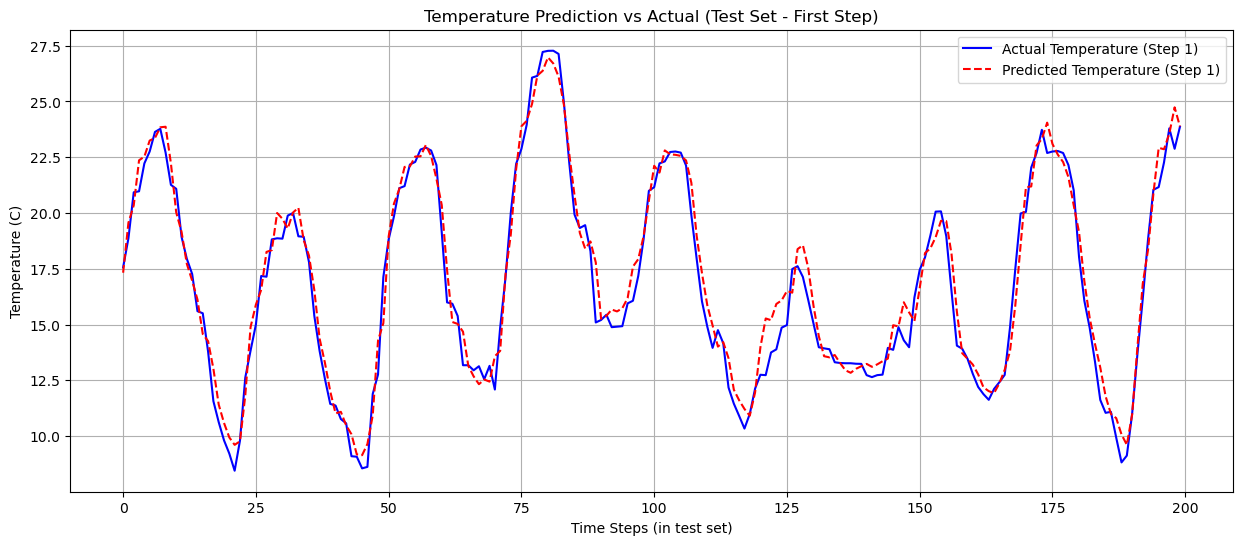


RDT Quick Validation Run Finished.


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os
import math # For positional encoding

# --- Configuration ---
DATA_PATH = 'weatherHistory.csv'
TARGET_COLUMN = 'Temperature (C)'
# Select features relevant for prediction + the target itself
FEATURE_COLUMNS = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)']
SEQ_LEN = 24  # Use past 24 hours
PRED_LEN = 3   # Predict next 3 hours
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10 # Keep low for quick testing
ALPHA_START = 0.2 # Initial weight for task loss
ALPHA_END = 0.8   # Final weight for task loss (approached linearly over epochs)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 1. Data Preprocessing Module ---

def load_and_preprocess_data(file_path, target_col, feature_cols, seq_len, pred_len):
    print("Loading and preprocessing data...")
    df = pd.read_csv(file_path)

    # Basic Cleaning & Feature Selection
    df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)
    df = df.set_index('Formatted Date')
    df = df.sort_index()

    # Ensure hourly frequency (handle potential duplicates/missing indices)
    # This might take a moment on large datasets
    df = df[~df.index.duplicated(keep='first')]
    df = df.asfreq('H') # Resample to hourly frequency

    # Select features + target
    df_features = df[feature_cols].copy()

    # Simple missing value handling (forward fill)
    df_features.ffill(inplace=True)
    df_features.bfill(inplace=True) # Backfill remaining NaNs at the beginning

    # Data Scaling (Fit only on training data!)
    n_features = df_features.shape[1]
    scaler = StandardScaler()

    # Temporal Splitting (70-15-15)
    n = len(df_features)
    train_end = int(n * 0.7)
    val_end = int(n * 0.85)

    train_data = df_features.iloc[:train_end].values
    val_data = df_features.iloc[train_end:val_end].values
    test_data = df_features.iloc[val_end:].values

    print(f"Raw data shapes: Train={train_data.shape}, Val={val_data.shape}, Test={test_data.shape}")

    # Fit scaler ONLY on training data
    scaler.fit(train_data)

    # Scale data
    train_scaled = scaler.transform(train_data)
    val_scaled = scaler.transform(val_data)
    test_scaled = scaler.transform(test_data)

    # Target column index
    try:
        target_col_index = feature_cols.index(target_col)
    except ValueError:
        raise ValueError(f"Target column '{target_col}' not found in feature columns: {feature_cols}")


    # Create sequences function
    def create_sequences(data, seq_len, pred_len, target_idx):
        xs, ys = [], []
        for i in range(len(data) - seq_len - pred_len + 1):
            x = data[i:(i + seq_len)]
            y = data[i + seq_len:i + seq_len + pred_len, target_idx] # Only target column
            xs.append(x)
            ys.append(y)
        # Ensure shapes are correct: X=(samples, seq_len, features), Y=(samples, pred_len)
        return np.array(xs), np.array(ys).reshape(-1, pred_len, 1) # Reshape Y to have a feature dim of 1

    # Generate sequences
    X_train, Y_true_train = create_sequences(train_scaled, seq_len, pred_len, target_col_index)
    X_val, Y_true_val = create_sequences(val_scaled, seq_len, pred_len, target_col_index)
    X_test, Y_true_test = create_sequences(test_scaled, seq_len, pred_len, target_col_index)

    print(f"Sequence shapes: X_train={X_train.shape}, Y_true_train={Y_true_train.shape}")
    print(f"Sequence shapes: X_val={X_val.shape}, Y_true_val={Y_true_val.shape}")
    print(f"Sequence shapes: X_test={X_test.shape}, Y_true_test={Y_true_test.shape}")

    return X_train, Y_true_train, X_val, Y_true_val, X_test, Y_true_test, scaler, target_col_index, n_features

# --- 2. Linear Teacher Model ---

def train_and_predict_linear_teacher(X_train, Y_true_train, X_val, pred_len, n_features):
    print("Training Linear Teacher Model...")
    # Reshape X for scikit-learn LinearRegression (samples, features*seq_len)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)

    # Reshape Y (samples, pred_len) - assuming single target feature prediction
    Y_true_train_flat = Y_true_train.reshape(Y_true_train.shape[0], -1)

    teacher_model = LinearRegression()
    teacher_model.fit(X_train_flat, Y_true_train_flat)

    print("Generating Teacher Predictions (Soft Labels)...")
    Y_linear_train_flat = teacher_model.predict(X_train_flat)
    Y_linear_val_flat = teacher_model.predict(X_val_flat)

    # Reshape back to (samples, pred_len, 1) to match student output
    Y_linear_train = Y_linear_train_flat.reshape(-1, pred_len, 1)
    Y_linear_val = Y_linear_val_flat.reshape(-1, pred_len, 1)

    print(f"Teacher prediction shapes: Train={Y_linear_train.shape}, Val={Y_linear_val.shape}")
    return Y_linear_train, Y_linear_val

# --- 3. Transformer Student Model ---

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (seq_len, batch_size, d_model)
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerStudentModel(nn.Module):
    def __init__(self, n_features, d_model, n_heads, num_encoder_layers, dim_feedforward, pred_len, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.input_projection = nn.Linear(n_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, n_heads, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        # Output layer projects the encoding of the *last* sequence element (or average?)
        # Let's try projecting the output of all sequence elements and then averaging/flattening
        self.output_projection1 = nn.Linear(d_model * SEQ_LEN, d_model * 2) # Project flattened encoder output
        self.relu = nn.ReLU()
        self.output_projection2 = nn.Linear(d_model * 2, pred_len * 1) # Predict pred_len steps for 1 target feature
        self.pred_len = pred_len

    def forward(self, src):
        # src shape: (batch_size, seq_len, n_features)
        src = self.input_projection(src) * math.sqrt(self.d_model)
        # Transformer Encoder expects (seq_len, batch_size, d_model) if batch_first=False
        # Or (batch_size, seq_len, d_model) if batch_first=True
        # Our PositionalEncoding expects (seq_len, batch_size, d_model) -> Let's adapt PE or transpose input
        # Easiest: Adapt model assuming batch_first=True for encoder layer
        # src = src.permute(1, 0, 2) # If needed and batch_first=False
        # src = self.pos_encoder(src) # Apply PE
        # src = src.permute(1, 0, 2) # Back to (batch_size, seq_len, d_model) if needed
        # Simpler PE application if batch_first=True
        # Note: Standard PE adds to dim 1 (seq len), need to adapt or ensure input matches
        # Quick Fix for PE with batch_first=True: Add PE after projection, before encoder
        # Need a PE that works with (batch_size, seq_len, d_model) or transpose temporarily
        # Let's skip PE for the very first quick validation pass for simplicity. Add it back later.
        # print(f"Input shape to encoder: {src.shape}") # Should be (batch, seq_len, d_model)
        output = self.transformer_encoder(src) # shape: (batch_size, seq_len, d_model)
        # print(f"Encoder output shape: {output.shape}")

        # Flatten the output sequence encoding for the final linear layers
        output = output.reshape(output.size(0), -1) # (batch_size, seq_len * d_model)
        # print(f"Flattened output shape: {output.shape}")

        output = self.relu(self.output_projection1(output))
        output = self.output_projection2(output) # (batch_size, pred_len * 1)
        # print(f"Final projection shape: {output.shape}")

        # Reshape to (batch_size, pred_len, n_target_features=1)
        output = output.view(-1, self.pred_len, 1)
        # print(f"Final output shape: {output.shape}")
        return output


# --- 4. Reverse Distillation Trainer ---

def get_alpha(current_epoch, total_epochs, alpha_start, alpha_end):
    """Linearly increase alpha from start to end over epochs."""
    return alpha_start + (alpha_end - alpha_start) * (current_epoch / total_epochs)

def train_rdt_model(student_model, X_train, Y_true_train, Y_linear_train, X_val, Y_true_val, Y_linear_val,
                    epochs, batch_size, lr, alpha_start, alpha_end, device):
    print("Starting RDT Training...")
    train_dataset = TensorDataset(torch.FloatTensor(X_train).to(device),
                                  torch.FloatTensor(Y_true_train).to(device),
                                  torch.FloatTensor(Y_linear_train).to(device))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(torch.FloatTensor(X_val).to(device),
                                torch.FloatTensor(Y_true_val).to(device),
                                torch.FloatTensor(Y_linear_val).to(device))
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer = optim.AdamW(student_model.parameters(), lr=lr)
    criterion_task = nn.MSELoss()
    criterion_distill = nn.MSELoss()

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):
        student_model.train()
        total_train_loss = 0
        total_task_loss_train = 0
        total_distill_loss_train = 0

        current_alpha = get_alpha(epoch, epochs, alpha_start, alpha_end)
        print(f"\nEpoch {epoch+1}/{epochs}, Current Alpha: {current_alpha:.4f}")

        for X_batch, Y_true_batch, Y_linear_batch in train_loader:
            optimizer.zero_grad()

            # Forward pass
            Y_pred_batch = student_model(X_batch)

            # Calculate losses
            loss_task = criterion_task(Y_pred_batch, Y_true_batch)
            loss_distill = criterion_distill(Y_pred_batch, Y_linear_batch)

            # Combine losses
            loss_total = current_alpha * loss_task + (1 - current_alpha) * loss_distill

            # Backward pass and optimize
            loss_total.backward()
            optimizer.step()

            total_train_loss += loss_total.item()
            total_task_loss_train += loss_task.item()
            total_distill_loss_train += loss_distill.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_task_loss_train = total_task_loss_train / len(train_loader)
        avg_distill_loss_train = total_distill_loss_train / len(train_loader)
        print(f"Avg Train Loss: {avg_train_loss:.4f} (Task: {avg_task_loss_train:.4f}, Distill: {avg_distill_loss_train:.4f})")

        # Validation step
        student_model.eval()
        total_val_loss_task = 0
        with torch.no_grad():
            for X_batch_val, Y_true_batch_val, Y_linear_batch_val in val_loader:
                Y_pred_batch_val = student_model(X_batch_val)
                val_loss_task = criterion_task(Y_pred_batch_val, Y_true_batch_val)
                # We primarily care about task loss on validation for model selection
                total_val_loss_task += val_loss_task.item()

        avg_val_loss_task = total_val_loss_task / len(val_loader)
        print(f"Avg Validation Task Loss (MSE): {avg_val_loss_task:.4f}")

        # Save best model based on validation task loss
        if avg_val_loss_task < best_val_loss:
            best_val_loss = avg_val_loss_task
            best_model_state = student_model.state_dict()
            print(f"*** New best validation loss: {best_val_loss:.4f}. Saving model state. ***")

    # Load best model weights
    if best_model_state:
        student_model.load_state_dict(best_model_state)
        print("Loaded best model weights based on validation loss.")
    else:
        print("Warning: No best model state saved (validation loss might not have improved).")

    return student_model


# --- 5. Inference Engine ---

def predict_on_test(model, X_test, scaler, target_col_index, batch_size, device):
    print("Running inference on test set...")
    model.eval()
    test_dataset = TensorDataset(torch.FloatTensor(X_test).to(device))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_preds_scaled = []
    with torch.no_grad():
        for X_batch, in test_loader: # Only need X for prediction
             Y_pred_batch_scaled = model(X_batch)
             all_preds_scaled.append(Y_pred_batch_scaled.cpu().numpy())

    # Concatenate predictions from all batches
    Y_pred_test_scaled = np.concatenate(all_preds_scaled, axis=0)
    print(f"Raw prediction shape (scaled): {Y_pred_test_scaled.shape}") # Should be (n_test_samples, pred_len, 1)

    # Inverse transform predictions
    # Scaler expects (n_samples, n_features). We need to carefully place our predicted target values
    # into an array of the correct shape, inverse transform, and then extract the target column.

    # Create a dummy array with the shape scaler expects for the number of predictions made
    # We need to repeat the prediction for each time step to fill the feature dimension
    num_samples = Y_pred_test_scaled.shape[0]
    num_features = scaler.n_features_in_
    pred_len = Y_pred_test_scaled.shape[1]

    # Placeholder for inverse transformation - needs careful handling per timestep
    Y_pred_test_inv = np.zeros((num_samples, pred_len, 1))

    # Process each prediction step separately for inverse scaling
    for step in range(pred_len):
        dummy_array = np.zeros((num_samples, num_features))
        # Place the scaled predictions for this step into the target column
        dummy_array[:, target_col_index] = Y_pred_test_scaled[:, step, 0]
        # Inverse transform
        inversed_array = scaler.inverse_transform(dummy_array)
        # Extract the inverse-transformed target column for this step
        Y_pred_test_inv[:, step, 0] = inversed_array[:, target_col_index]

    print(f"Final prediction shape (inverse-scaled): {Y_pred_test_inv.shape}")
    return Y_pred_test_inv


# --- 6. Evaluation Module ---

def evaluate_predictions(Y_true_test, Y_pred_test, scaler, target_col_index):
    print("Evaluating predictions...")

    # Inverse transform ground truth Y_true_test (which is already scaled)
    num_samples = Y_true_test.shape[0]
    num_features = scaler.n_features_in_
    pred_len = Y_true_test.shape[1]

    Y_true_test_inv = np.zeros((num_samples, pred_len, 1))

    for step in range(pred_len):
        dummy_array = np.zeros((num_samples, num_features))
        dummy_array[:, target_col_index] = Y_true_test[:, step, 0]
        inversed_array = scaler.inverse_transform(dummy_array)
        Y_true_test_inv[:, step, 0] = inversed_array[:, target_col_index]

    print(f"Shape of inverse-scaled True Y: {Y_true_test_inv.shape}")
    print(f"Shape of inverse-scaled Predicted Y: {Y_pred_test.shape}")


    # Calculate metrics for each prediction step
    mses, maes = [], []
    for step in range(pred_len):
        mse = mean_squared_error(Y_true_test_inv[:, step, 0], Y_pred_test[:, step, 0])
        mae = mean_absolute_error(Y_true_test_inv[:, step, 0], Y_pred_test[:, step, 0])
        mses.append(mse)
        maes.append(mae)
        print(f"Step {step+1}/{pred_len} - MSE: {mse:.4f}, MAE: {mae:.4f}")

    avg_mse = np.mean(mses)
    avg_mae = np.mean(maes)
    print(f"\nAverage over {pred_len} steps - MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}")

    # --- Visualization ---
    # Plot predictions vs actual for a sample period from the test set
    plt.figure(figsize=(15, 6))
    # Plotting the first prediction step only for clarity
    plot_len = min(200, len(Y_true_test_inv)) # Plot first 200 points or less
    plt.plot(Y_true_test_inv[:plot_len, 0, 0], label='Actual Temperature (Step 1)', color='blue')
    plt.plot(Y_pred_test[:plot_len, 0, 0], label='Predicted Temperature (Step 1)', color='red', linestyle='--')
    plt.title('Temperature Prediction vs Actual (Test Set - First Step)')
    plt.xlabel('Time Steps (in test set)')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.grid(True)
    # Save the plot
    plot_filename = "rdt_prediction_vs_actual.png"
    plt.savefig(plot_filename)
    print(f"Saved prediction plot to {plot_filename}")
    plt.show()

    return avg_mse, avg_mae


# --- Main Execution ---
if __name__ == "__main__":
    # 1. Load and Preprocess Data
    X_train, Y_true_train, X_val, Y_true_val, X_test, Y_true_test, scaler, target_col_index, n_features = \
        load_and_preprocess_data(DATA_PATH, TARGET_COLUMN, FEATURE_COLUMNS, SEQ_LEN, PRED_LEN)

    # 2. Train Linear Teacher and get Soft Labels
    Y_linear_train, Y_linear_val = train_and_predict_linear_teacher(
        X_train, Y_true_train, X_val, PRED_LEN, n_features
    )

    # 3. Initialize Transformer Student Model
    # Hyperparameters for the Transformer (can be tuned)
    D_MODEL = 64
    N_HEADS = 4
    NUM_ENCODER_LAYERS = 2
    DIM_FEEDFORWARD = 128
    DROPOUT = 0.1

    student_model = TransformerStudentModel(
        n_features=n_features,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        num_encoder_layers=NUM_ENCODER_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD,
        pred_len=PRED_LEN,
        dropout=DROPOUT
    ).to(DEVICE)

    print("\nStudent Model Architecture:")
    print(student_model)
    num_params = sum(p.numel() for p in student_model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {num_params}")


    # 4. Train the RDT Model
    trained_student_model = train_rdt_model(
        student_model,
        X_train, Y_true_train, Y_linear_train,
        X_val, Y_true_val, Y_linear_val,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        lr=LEARNING_RATE,
        alpha_start=ALPHA_START,
        alpha_end=ALPHA_END,
        device=DEVICE
    )

    # 5. Inference on Test Set
    Y_pred_test = predict_on_test(
        trained_student_model, X_test, scaler, target_col_index, BATCH_SIZE, DEVICE
    )

    # 6. Evaluate
    evaluate_predictions(Y_true_test, Y_pred_test, scaler, target_col_index)

    print("\nRDT Quick Validation Run Finished.")

    # --- To compare with baselines (you'd run these separately) ---
    # Baseline 1: Pure Linear Teacher (evaluate its predictions on X_test directly)
    # Baseline 2: Pure Transformer (train with alpha=1.0)
    # Baseline 3: Simple Ensemble (train separately, average predictions)


## 比较（预测步长：24h）

Using device: cpu
Loading and preprocessing data...


C:\Users\24228\AppData\Local\Temp\ipykernel_29840\4122123480.py:42: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq('H') # Resample to hourly frequency


Raw data shapes: Train=(67502, 3), Val=(14465, 3), Test=(14465, 3)
Sequence shapes: X_train=(67455, 24, 3), Y_true_train=(67455, 24, 1)
Sequence shapes: X_val=(14418, 24, 3), Y_true_val=(14418, 24, 1)
Sequence shapes: X_test=(14418, 24, 3), Y_true_test=(14418, 24, 1)

=== Evaluating Linear Teacher (Approach 1) ===
Training Linear Teacher Model...
Generating Teacher Predictions (Soft Labels)...
Teacher prediction shapes: Train=(67455, 24, 1), Val=(14418, 24, 1)
Running inference on test set...
Final prediction shape (inverse-scaled): (14418, 24, 1)

Evaluating Linear Teacher predictions...
Shape of inverse-scaled True Y: (14418, 24, 1)
Shape of inverse-scaled Predicted Y: (14418, 24, 1)
Step 1/24 - MSE: 0.7758, MAE: 0.6316
Step 2/24 - MSE: 1.7191, MAE: 0.9569
Step 3/24 - MSE: 2.6960, MAE: 1.2070
Step 4/24 - MSE: 3.6429, MAE: 1.4018
Step 5/24 - MSE: 4.4694, MAE: 1.5491
Step 6/24 - MSE: 5.1602, MAE: 1.6618
Step 7/24 - MSE: 5.7324, MAE: 1.7503
Step 8/24 - MSE: 6.2028, MAE: 1.8172
Step 9/24

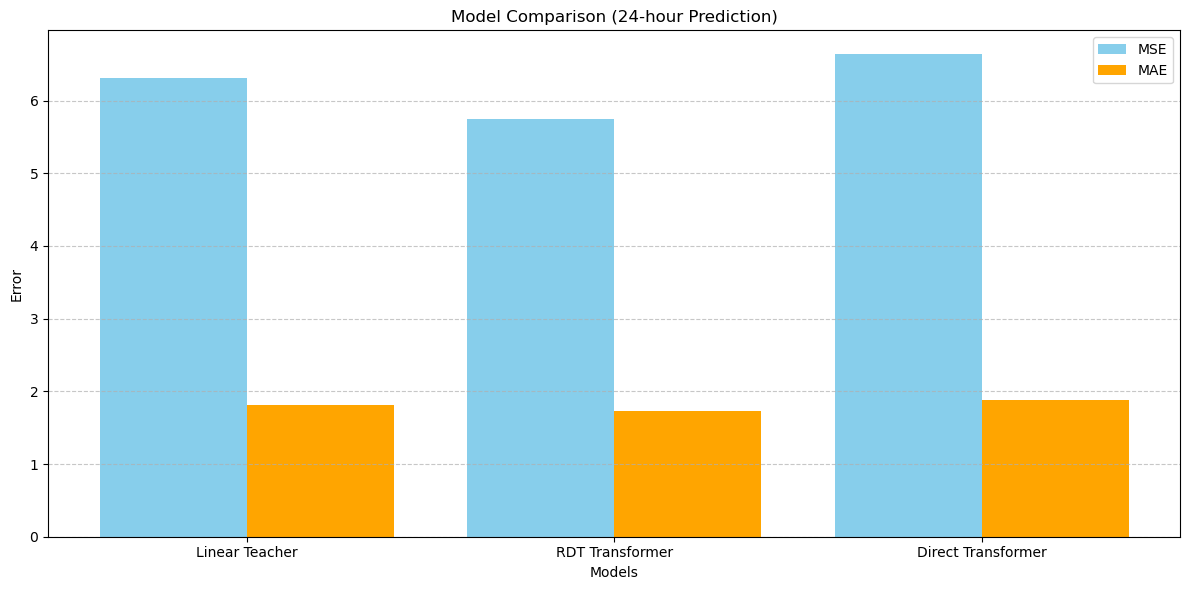


All evaluations completed!


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os
import math # For positional encoding

# --- Configuration ---
DATA_PATH = 'weatherHistory.csv'
TARGET_COLUMN = 'Temperature (C)'
# Select features relevant for prediction + the target itself
FEATURE_COLUMNS = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)']
SEQ_LEN = 24  # Use past 24 hours
PRED_LEN = 24   # Predict next 24 hours
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10 # Keep low for quick testing
ALPHA_START = 0.2 # Initial weight for task loss
ALPHA_END = 0.8   # Final weight for task loss (approached linearly over epochs)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 1. Data Preprocessing Module ---

def load_and_preprocess_data(file_path, target_col, feature_cols, seq_len, pred_len):
    print("Loading and preprocessing data...")
    df = pd.read_csv(file_path)

    # Basic Cleaning & Feature Selection
    df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)
    df = df.set_index('Formatted Date')
    df = df.sort_index()

    # Ensure hourly frequency (handle potential duplicates/missing indices)
    df = df[~df.index.duplicated(keep='first')]
    df = df.asfreq('H') # Resample to hourly frequency

    # Select features + target
    df_features = df[feature_cols].copy()

    # Simple missing value handling (forward fill)
    df_features.ffill(inplace=True)
    df_features.bfill(inplace=True) # Backfill remaining NaNs at the beginning

    # Data Scaling (Fit only on training data!)
    n_features = df_features.shape[1]
    scaler = StandardScaler()

    # Temporal Splitting (70-15-15)
    n = len(df_features)
    train_end = int(n * 0.7)
    val_end = int(n * 0.85)

    train_data = df_features.iloc[:train_end].values
    val_data = df_features.iloc[train_end:val_end].values
    test_data = df_features.iloc[val_end:].values

    print(f"Raw data shapes: Train={train_data.shape}, Val={val_data.shape}, Test={test_data.shape}")

    # Fit scaler ONLY on training data
    scaler.fit(train_data)

    # Scale data
    train_scaled = scaler.transform(train_data)
    val_scaled = scaler.transform(val_data)
    test_scaled = scaler.transform(test_data)

    # Target column index
    try:
        target_col_index = feature_cols.index(target_col)
    except ValueError:
        raise ValueError(f"Target column '{target_col}' not found in feature columns: {feature_cols}")

    # Create sequences function
    def create_sequences(data, seq_len, pred_len, target_idx):
        xs, ys = [], []
        for i in range(len(data) - seq_len - pred_len + 1):
            x = data[i:(i + seq_len)]
            y = data[i + seq_len:i + seq_len + pred_len, target_idx] # Only target column
            xs.append(x)
            ys.append(y)
        # Ensure shapes are correct: X=(samples, seq_len, features), Y=(samples, pred_len)
        return np.array(xs), np.array(ys).reshape(-1, pred_len, 1) # Reshape Y to have a feature dim of 1

    # Generate sequences
    X_train, Y_true_train = create_sequences(train_scaled, seq_len, pred_len, target_col_index)
    X_val, Y_true_val = create_sequences(val_scaled, seq_len, pred_len, target_col_index)
    X_test, Y_true_test = create_sequences(test_scaled, seq_len, pred_len, target_col_index)

    print(f"Sequence shapes: X_train={X_train.shape}, Y_true_train={Y_true_train.shape}")
    print(f"Sequence shapes: X_val={X_val.shape}, Y_true_val={Y_true_val.shape}")
    print(f"Sequence shapes: X_test={X_test.shape}, Y_true_test={Y_true_test.shape}")

    return X_train, Y_true_train, X_val, Y_true_val, X_test, Y_true_test, scaler, target_col_index, n_features

# --- 2. Linear Teacher Model ---

def train_and_predict_linear_teacher(X_train, Y_true_train, X_val, pred_len, n_features):
    print("Training Linear Teacher Model...")
    # Reshape X for scikit-learn LinearRegression (samples, features*seq_len)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)

    # Reshape Y (samples, pred_len) - assuming single target feature prediction
    Y_true_train_flat = Y_true_train.reshape(Y_true_train.shape[0], -1)

    teacher_model = LinearRegression()
    teacher_model.fit(X_train_flat, Y_true_train_flat)

    print("Generating Teacher Predictions (Soft Labels)...")
    Y_linear_train_flat = teacher_model.predict(X_train_flat)
    Y_linear_val_flat = teacher_model.predict(X_val_flat)

    # Reshape back to (samples, pred_len, 1) to match student output
    Y_linear_train = Y_linear_train_flat.reshape(-1, pred_len, 1)
    Y_linear_val = Y_linear_val_flat.reshape(-1, pred_len, 1)

    print(f"Teacher prediction shapes: Train={Y_linear_train.shape}, Val={Y_linear_val.shape}")
    return teacher_model, Y_linear_train, Y_linear_val

# --- 3. Transformer Student Model ---

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerStudentModel(nn.Module):
    def __init__(self, n_features, d_model, n_heads, num_encoder_layers, dim_feedforward, pred_len, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.input_projection = nn.Linear(n_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, n_heads, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.output_projection1 = nn.Linear(d_model * SEQ_LEN, d_model * 2)
        self.relu = nn.ReLU()
        self.output_projection2 = nn.Linear(d_model * 2, pred_len * 1)
        self.pred_len = pred_len

    def forward(self, src):
        src = self.input_projection(src) * math.sqrt(self.d_model)
        output = self.transformer_encoder(src)
        output = output.reshape(output.size(0), -1)
        output = self.relu(self.output_projection1(output))
        output = self.output_projection2(output)
        output = output.view(-1, self.pred_len, 1)
        return output

# --- 4. Reverse Distillation Trainer ---

def get_alpha(current_epoch, total_epochs, alpha_start, alpha_end):
    """Linearly increase alpha from start to end over epochs."""
    return alpha_start + (alpha_end - alpha_start) * (current_epoch / total_epochs)

def train_rdt_model(student_model, X_train, Y_true_train, Y_linear_train, X_val, Y_true_val, Y_linear_val,
                    epochs, batch_size, lr, alpha_start, alpha_end, device):
    print("Starting RDT Training...")
    train_dataset = TensorDataset(torch.FloatTensor(X_train).to(device),
                                torch.FloatTensor(Y_true_train).to(device),
                                torch.FloatTensor(Y_linear_train).to(device))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(torch.FloatTensor(X_val).to(device),
                              torch.FloatTensor(Y_true_val).to(device),
                              torch.FloatTensor(Y_linear_val).to(device))
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer = optim.AdamW(student_model.parameters(), lr=lr)
    criterion_task = nn.MSELoss()
    criterion_distill = nn.MSELoss()

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):
        student_model.train()
        total_train_loss = 0
        total_task_loss_train = 0
        total_distill_loss_train = 0

        current_alpha = get_alpha(epoch, epochs, alpha_start, alpha_end)
        print(f"\nEpoch {epoch+1}/{epochs}, Current Alpha: {current_alpha:.4f}")

        for X_batch, Y_true_batch, Y_linear_batch in train_loader:
            optimizer.zero_grad()

            # Forward pass
            Y_pred_batch = student_model(X_batch)

            # Calculate losses
            loss_task = criterion_task(Y_pred_batch, Y_true_batch)
            loss_distill = criterion_distill(Y_pred_batch, Y_linear_batch)

            # Combine losses
            loss_total = current_alpha * loss_task + (1 - current_alpha) * loss_distill

            # Backward pass and optimize
            loss_total.backward()
            optimizer.step()

            total_train_loss += loss_total.item()
            total_task_loss_train += loss_task.item()
            total_distill_loss_train += loss_distill.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_task_loss_train = total_task_loss_train / len(train_loader)
        avg_distill_loss_train = total_distill_loss_train / len(train_loader)
        print(f"Avg Train Loss: {avg_train_loss:.4f} (Task: {avg_task_loss_train:.4f}, Distill: {avg_distill_loss_train:.4f})")

        # Validation step
        student_model.eval()
        total_val_loss_task = 0
        with torch.no_grad():
            for X_batch_val, Y_true_batch_val, Y_linear_batch_val in val_loader:
                Y_pred_batch_val = student_model(X_batch_val)
                val_loss_task = criterion_task(Y_pred_batch_val, Y_true_batch_val)
                total_val_loss_task += val_loss_task.item()

        avg_val_loss_task = total_val_loss_task / len(val_loader)
        print(f"Avg Validation Task Loss (MSE): {avg_val_loss_task:.4f}")

        # Save best model based on validation task loss
        if avg_val_loss_task < best_val_loss:
            best_val_loss = avg_val_loss_task
            best_model_state = student_model.state_dict()
            print(f"*** New best validation loss: {best_val_loss:.4f}. Saving model state. ***")

    # Load best model weights
    if best_model_state:
        student_model.load_state_dict(best_model_state)
        print("Loaded best model weights based on validation loss.")
    else:
        print("Warning: No best model state saved (validation loss might not have improved).")

    return student_model

# --- 5. Inference Engine ---

def predict_on_test(model, X_test, scaler, target_col_index, batch_size, device, is_linear=False):
    print("Running inference on test set...")
    
    if is_linear:
        # Handle linear model case
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        Y_pred_test_scaled = model.predict(X_test_flat)
        Y_pred_test_scaled = Y_pred_test_scaled.reshape(-1, PRED_LEN, 1)
    else:
        # Handle neural network case
        model.eval()
        test_dataset = TensorDataset(torch.FloatTensor(X_test).to(device))
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        all_preds_scaled = []
        with torch.no_grad():
            for X_batch, in test_loader:
                Y_pred_batch_scaled = model(X_batch)
                all_preds_scaled.append(Y_pred_batch_scaled.cpu().numpy())
        Y_pred_test_scaled = np.concatenate(all_preds_scaled, axis=0)

    # Inverse transform predictions
    num_samples = Y_pred_test_scaled.shape[0]
    num_features = scaler.n_features_in_
    pred_len = Y_pred_test_scaled.shape[1]

    Y_pred_test_inv = np.zeros((num_samples, pred_len, 1))

    for step in range(pred_len):
        dummy_array = np.zeros((num_samples, num_features))
        dummy_array[:, target_col_index] = Y_pred_test_scaled[:, step, 0]
        inversed_array = scaler.inverse_transform(dummy_array)
        Y_pred_test_inv[:, step, 0] = inversed_array[:, target_col_index]

    print(f"Final prediction shape (inverse-scaled): {Y_pred_test_inv.shape}")
    return Y_pred_test_inv

# --- 6. Evaluation Module ---

def evaluate_predictions(Y_true_test, Y_pred_test, scaler, target_col_index, model_name="Model"):
    print(f"\nEvaluating {model_name} predictions...")

    # Inverse transform ground truth Y_true_test (which is already scaled)
    num_samples = Y_true_test.shape[0]
    num_features = scaler.n_features_in_
    pred_len = Y_true_test.shape[1]

    Y_true_test_inv = np.zeros((num_samples, pred_len, 1))

    for step in range(pred_len):
        dummy_array = np.zeros((num_samples, num_features))
        dummy_array[:, target_col_index] = Y_true_test[:, step, 0]
        inversed_array = scaler.inverse_transform(dummy_array)
        Y_true_test_inv[:, step, 0] = inversed_array[:, target_col_index]

    print(f"Shape of inverse-scaled True Y: {Y_true_test_inv.shape}")
    print(f"Shape of inverse-scaled Predicted Y: {Y_pred_test.shape}")

    # Calculate metrics for each prediction step
    mses, maes = [], []
    for step in range(pred_len):
        mse = mean_squared_error(Y_true_test_inv[:, step, 0], Y_pred_test[:, step, 0])
        mae = mean_absolute_error(Y_true_test_inv[:, step, 0], Y_pred_test[:, step, 0])
        mses.append(mse)
        maes.append(mae)
        print(f"Step {step+1}/{pred_len} - MSE: {mse:.4f}, MAE: {mae:.4f}")

    avg_mse = np.mean(mses)
    avg_mae = np.mean(maes)
    print(f"\n{model_name} Average over {pred_len} steps - MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}")

    # Plot predictions vs actual for first prediction step
    plt.figure(figsize=(15, 6))
    plot_len = min(200, len(Y_true_test_inv))
    plt.plot(Y_true_test_inv[:plot_len, 0, 0], label='Actual Temperature (Step 1)', color='blue')
    plt.plot(Y_pred_test[:plot_len, 0, 0], label=f'{model_name} Predicted (Step 1)', 
             color='red' if "Linear" in model_name else 'green' if "RDT" in model_name else 'purple', 
             linestyle='--')
    plt.title(f'Temperature Prediction vs Actual ({model_name})')
    plt.xlabel('Time Steps (in test set)')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.grid(True)
    plot_filename = f"{model_name.lower().replace(' ', '_')}_prediction_vs_actual.png"
    plt.savefig(plot_filename)
    print(f"Saved prediction plot to {plot_filename}")
    plt.close()

    return avg_mse, avg_mae

# --- Main Execution ---
if __name__ == "__main__":
    # 1. Load and Preprocess Data
    X_train, Y_true_train, X_val, Y_true_val, X_test, Y_true_test, scaler, target_col_index, n_features = \
        load_and_preprocess_data(DATA_PATH, TARGET_COLUMN, FEATURE_COLUMNS, SEQ_LEN, PRED_LEN)

    # --- Approach 1: Linear Teacher ---
    print("\n=== Evaluating Linear Teacher (Approach 1) ===")
    teacher_model, Y_linear_train, Y_linear_val = train_and_predict_linear_teacher(
        X_train, Y_true_train, X_val, PRED_LEN, n_features
    )
    
    # Get teacher predictions on test set
    Y_linear_test_inv = predict_on_test(teacher_model, X_test, scaler, target_col_index, BATCH_SIZE, DEVICE, is_linear=True)
    linear_mse, linear_mae = evaluate_predictions(Y_true_test, Y_linear_test_inv, scaler, target_col_index, "Linear Teacher")

    # --- Approach 2: RDT-trained Transformer ---
    print("\n=== Evaluating RDT-trained Transformer (Approach 2) ===")
    # Initialize Transformer Student Model
    D_MODEL = 64
    N_HEADS = 4
    NUM_ENCODER_LAYERS = 2
    DIM_FEEDFORWARD = 128
    DROPOUT = 0.1

    student_model = TransformerStudentModel(
        n_features=n_features,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        num_encoder_layers=NUM_ENCODER_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD,
        pred_len=PRED_LEN,
        dropout=DROPOUT
    ).to(DEVICE)

    print("\nStudent Model Architecture:")
    print(student_model)
    num_params = sum(p.numel() for p in student_model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {num_params}")

    # Train the RDT Model
    trained_student_model = train_rdt_model(
        student_model,
        X_train, Y_true_train, Y_linear_train,
        X_val, Y_true_val, Y_linear_val,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        lr=LEARNING_RATE,
        alpha_start=ALPHA_START,
        alpha_end=ALPHA_END,
        device=DEVICE
    )

    # Evaluate on test set
    Y_rdt_test = predict_on_test(trained_student_model, X_test, scaler, target_col_index, BATCH_SIZE, DEVICE)
    rdt_mse, rdt_mae = evaluate_predictions(Y_true_test, Y_rdt_test, scaler, target_col_index, "RDT Transformer")

    # --- Approach 3: Transformer trained with True Labels Only ---
    print("\n=== Evaluating Directly-trained Transformer (Approach 3) ===")
    # Initialize another Transformer with same architecture
    direct_transformer = TransformerStudentModel(
        n_features=n_features,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        num_encoder_layers=NUM_ENCODER_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD,
        pred_len=PRED_LEN,
        dropout=DROPOUT
    ).to(DEVICE)

    # Train with alpha=1.0 (only true labels)
    # We'll reuse the RDT training function but set alpha to always be 1.0
    direct_transformer = train_rdt_model(
        direct_transformer,
        X_train, Y_true_train, Y_linear_train,  # Y_linear_train won't be used
        X_val, Y_true_val, Y_linear_val,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        lr=LEARNING_RATE,
        alpha_start=1.0,  # Always 1.0 = only true labels
        alpha_end=1.0,
        device=DEVICE
    )

    # Evaluate on test set
    Y_direct_test = predict_on_test(direct_transformer, X_test, scaler, target_col_index, BATCH_SIZE, DEVICE)
    direct_mse, direct_mae = evaluate_predictions(Y_true_test, Y_direct_test, scaler, target_col_index, "Direct Transformer")

    # --- Final Comparison ---
    print("\n=== Final Comparison ===")
    print(f"Linear Teacher:      MSE = {linear_mse:.4f}, MAE = {linear_mae:.4f}")
    print(f"RDT Transformer:     MSE = {rdt_mse:.4f}, MAE = {rdt_mae:.4f}")
    print(f"Direct Transformer:  MSE = {direct_mse:.4f}, MAE = {direct_mae:.4f}")

    # Plot comparison
    plt.figure(figsize=(12, 6))
    models = ['Linear Teacher', 'RDT Transformer', 'Direct Transformer']
    mses = [linear_mse, rdt_mse, direct_mse]
    maes = [linear_mae, rdt_mae, direct_mae]
    
    x = range(len(models))
    plt.bar(x, mses, width=0.4, label='MSE', color='skyblue')
    plt.bar([i + 0.4 for i in x], maes, width=0.4, label='MAE', color='orange')
    
    plt.xlabel('Models')
    plt.ylabel('Error')
    plt.title('Model Comparison (24-hour Prediction)')
    plt.xticks([i + 0.2 for i in x], models)
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("model_comparison_24h.png")
    plt.show()

    print("\nAll evaluations completed!")

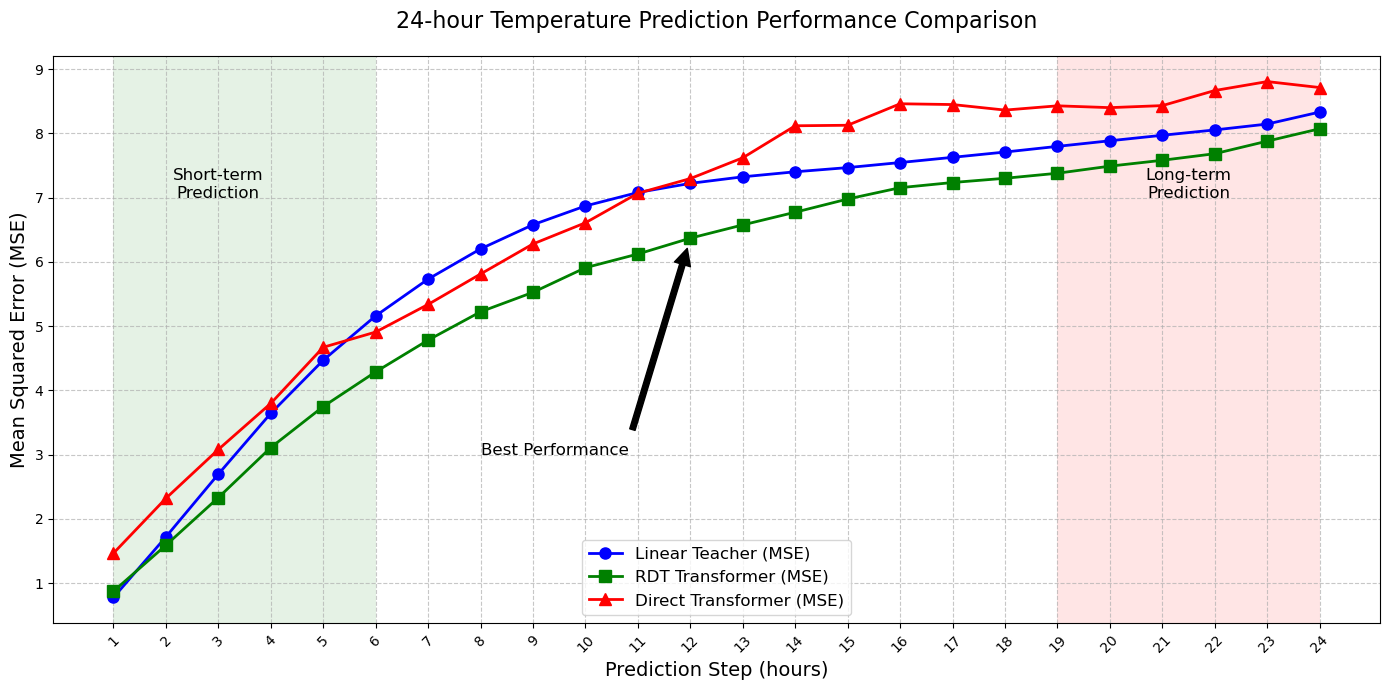

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 准备数据（从您的实验结果中提取）
steps = np.arange(1, 25)  # 1-24预测步长
linear_mse = [0.7758, 1.7191, 2.6960, 3.6429, 4.4694, 5.1602, 5.7324, 6.2028, 
              6.5789, 6.8711, 7.0806, 7.2227, 7.3245, 7.4028, 7.4680, 7.5467, 
              7.6277, 7.7102, 7.7985, 7.8857, 7.9712, 8.0545, 8.1459, 8.3326]
rdt_mse = [0.8723, 1.5896, 2.3310, 3.1098, 3.7482, 4.2881, 4.7825, 5.2233, 
           5.5265, 5.9098, 6.1226, 6.3696, 6.5758, 6.7735, 6.9789, 7.1553, 
           7.2359, 7.3019, 7.3801, 7.4906, 7.5821, 7.6844, 7.8800, 8.0726]
direct_mse = [1.4649, 2.3193, 3.0797, 3.7974, 4.6709, 4.9080, 5.3381, 5.8117, 
              6.2794, 6.6093, 7.0685, 7.2973, 7.6209, 8.1190, 8.1271, 8.4617, 
              8.4495, 8.3633, 8.4297, 8.4013, 8.4331, 8.6680, 8.8072, 8.7142]

# 创建画布
plt.figure(figsize=(14, 7))

# 绘制MSE曲线
plt.plot(steps, linear_mse, 'b-o', label='Linear Teacher (MSE)', linewidth=2, markersize=8)
plt.plot(steps, rdt_mse, 'g-s', label='RDT Transformer (MSE)', linewidth=2, markersize=8)
plt.plot(steps, direct_mse, 'r-^', label='Direct Transformer (MSE)', linewidth=2, markersize=8)

# 添加标注
plt.annotate('Best Performance', xy=(12, rdt_mse[11]), xytext=(8, 3),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12)

# 美化图表
plt.title('24-hour Temperature Prediction Performance Comparison', fontsize=16, pad=20)
plt.xlabel('Prediction Step (hours)', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.xticks(steps, rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# 添加背景色区分区域
plt.axvspan(1, 6, facecolor='green', alpha=0.1)
plt.axvspan(19, 24, facecolor='red', alpha=0.1)
plt.text(3, 7, 'Short-term\nPrediction', ha='center', fontsize=12)
plt.text(21.5, 7, 'Long-term\nPrediction', ha='center', fontsize=12)

# 保存并显示
plt.tight_layout()
plt.savefig('model_comparison_mse.png', dpi=300)
plt.show()

## 预测步长：72h

Using device: cpu
Loading and preprocessing data...


C:\Users\24228\AppData\Local\Temp\ipykernel_29840\2690259517.py:42: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq('H') # Resample to hourly frequency


Raw data shapes: Train=(67502, 3), Val=(14465, 3), Test=(14465, 3)
Sequence shapes: X_train=(67359, 72, 3), Y_true_train=(67359, 72, 1)
Sequence shapes: X_val=(14322, 72, 3), Y_true_val=(14322, 72, 1)
Sequence shapes: X_test=(14322, 72, 3), Y_true_test=(14322, 72, 1)

=== Evaluating Linear Teacher (Approach 1) ===
Training Linear Teacher Model...
Generating Teacher Predictions (Soft Labels)...
Teacher prediction shapes: Train=(67359, 72, 1), Val=(14322, 72, 1)
Running inference on test set...
Final prediction shape (inverse-scaled): (14322, 72, 1)

Evaluating Linear Teacher predictions...
Shape of inverse-scaled True Y: (14322, 72, 1)
Shape of inverse-scaled Predicted Y: (14322, 72, 1)
Step 1/72 - MSE: 0.7179, MAE: 0.6004
Step 2/72 - MSE: 1.5355, MAE: 0.8871
Step 3/72 - MSE: 2.4158, MAE: 1.1182
Step 4/72 - MSE: 3.2855, MAE: 1.3070
Step 5/72 - MSE: 4.0516, MAE: 1.4524
Step 6/72 - MSE: 4.7018, MAE: 1.5654
Step 7/72 - MSE: 5.2611, MAE: 1.6558
Step 8/72 - MSE: 5.7305, MAE: 1.7265
Step 9/72

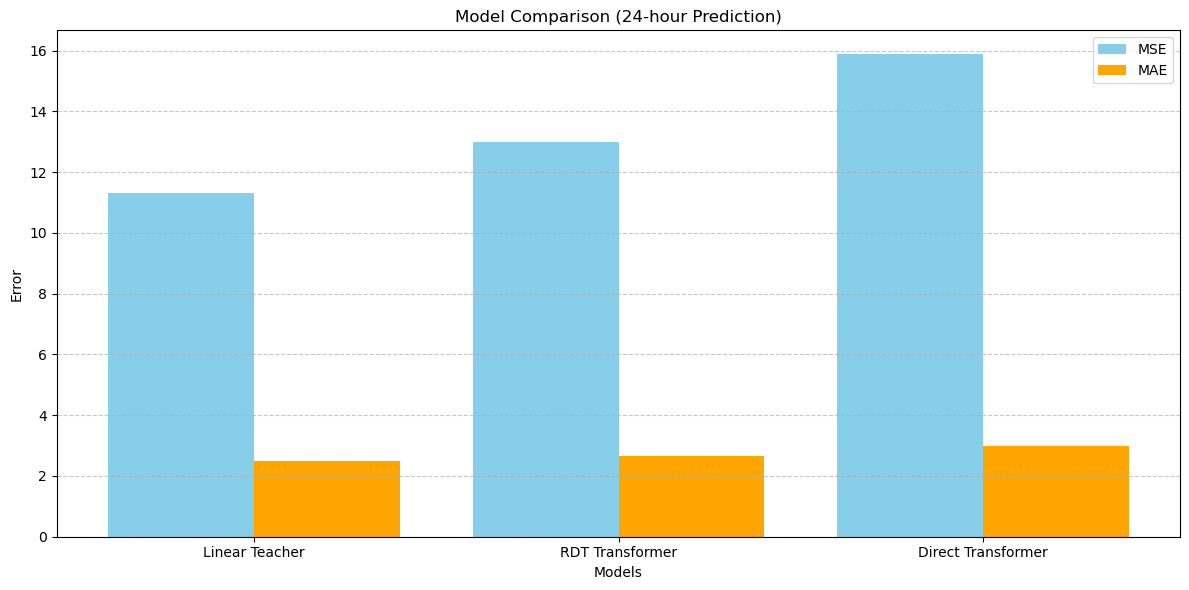


All evaluations completed!


In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os
import math # For positional encoding

# --- Configuration ---
DATA_PATH = 'weatherHistory.csv'
TARGET_COLUMN = 'Temperature (C)'
# Select features relevant for prediction + the target itself
FEATURE_COLUMNS = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)']
SEQ_LEN = 72  # Use past 24 hours
PRED_LEN = 72   # Predict next 24 hours
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS =20 # Keep low for quick testing
ALPHA_START = 0.2 # Initial weight for task loss
ALPHA_END = 0.8   # Final weight for task loss (approached linearly over epochs)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 1. Data Preprocessing Module ---

def load_and_preprocess_data(file_path, target_col, feature_cols, seq_len, pred_len):
    print("Loading and preprocessing data...")
    df = pd.read_csv(file_path)

    # Basic Cleaning & Feature Selection
    df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)
    df = df.set_index('Formatted Date')
    df = df.sort_index()

    # Ensure hourly frequency (handle potential duplicates/missing indices)
    df = df[~df.index.duplicated(keep='first')]
    df = df.asfreq('H') # Resample to hourly frequency

    # Select features + target
    df_features = df[feature_cols].copy()

    # Simple missing value handling (forward fill)
    df_features.ffill(inplace=True)
    df_features.bfill(inplace=True) # Backfill remaining NaNs at the beginning

    # Data Scaling (Fit only on training data!)
    n_features = df_features.shape[1]
    scaler = StandardScaler()

    # Temporal Splitting (70-15-15)
    n = len(df_features)
    train_end = int(n * 0.7)
    val_end = int(n * 0.85)

    train_data = df_features.iloc[:train_end].values
    val_data = df_features.iloc[train_end:val_end].values
    test_data = df_features.iloc[val_end:].values

    print(f"Raw data shapes: Train={train_data.shape}, Val={val_data.shape}, Test={test_data.shape}")

    # Fit scaler ONLY on training data
    scaler.fit(train_data)

    # Scale data
    train_scaled = scaler.transform(train_data)
    val_scaled = scaler.transform(val_data)
    test_scaled = scaler.transform(test_data)

    # Target column index
    try:
        target_col_index = feature_cols.index(target_col)
    except ValueError:
        raise ValueError(f"Target column '{target_col}' not found in feature columns: {feature_cols}")

    # Create sequences function
    def create_sequences(data, seq_len, pred_len, target_idx):
        xs, ys = [], []
        for i in range(len(data) - seq_len - pred_len + 1):
            x = data[i:(i + seq_len)]
            y = data[i + seq_len:i + seq_len + pred_len, target_idx] # Only target column
            xs.append(x)
            ys.append(y)
        # Ensure shapes are correct: X=(samples, seq_len, features), Y=(samples, pred_len)
        return np.array(xs), np.array(ys).reshape(-1, pred_len, 1) # Reshape Y to have a feature dim of 1

    # Generate sequences
    X_train, Y_true_train = create_sequences(train_scaled, seq_len, pred_len, target_col_index)
    X_val, Y_true_val = create_sequences(val_scaled, seq_len, pred_len, target_col_index)
    X_test, Y_true_test = create_sequences(test_scaled, seq_len, pred_len, target_col_index)

    print(f"Sequence shapes: X_train={X_train.shape}, Y_true_train={Y_true_train.shape}")
    print(f"Sequence shapes: X_val={X_val.shape}, Y_true_val={Y_true_val.shape}")
    print(f"Sequence shapes: X_test={X_test.shape}, Y_true_test={Y_true_test.shape}")

    return X_train, Y_true_train, X_val, Y_true_val, X_test, Y_true_test, scaler, target_col_index, n_features

# --- 2. Linear Teacher Model ---

def train_and_predict_linear_teacher(X_train, Y_true_train, X_val, pred_len, n_features):
    print("Training Linear Teacher Model...")
    # Reshape X for scikit-learn LinearRegression (samples, features*seq_len)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)

    # Reshape Y (samples, pred_len) - assuming single target feature prediction
    Y_true_train_flat = Y_true_train.reshape(Y_true_train.shape[0], -1)

    teacher_model = LinearRegression()
    teacher_model.fit(X_train_flat, Y_true_train_flat)

    print("Generating Teacher Predictions (Soft Labels)...")
    Y_linear_train_flat = teacher_model.predict(X_train_flat)
    Y_linear_val_flat = teacher_model.predict(X_val_flat)

    # Reshape back to (samples, pred_len, 1) to match student output
    Y_linear_train = Y_linear_train_flat.reshape(-1, pred_len, 1)
    Y_linear_val = Y_linear_val_flat.reshape(-1, pred_len, 1)

    print(f"Teacher prediction shapes: Train={Y_linear_train.shape}, Val={Y_linear_val.shape}")
    return teacher_model, Y_linear_train, Y_linear_val

# --- 3. Transformer Student Model ---

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerStudentModel(nn.Module):
    def __init__(self, n_features, d_model, n_heads, num_encoder_layers, dim_feedforward, pred_len, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.input_projection = nn.Linear(n_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, n_heads, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.output_projection1 = nn.Linear(d_model * SEQ_LEN, d_model * 2)
        self.relu = nn.ReLU()
        self.output_projection2 = nn.Linear(d_model * 2, pred_len * 1)
        self.pred_len = pred_len

    def forward(self, src):
        src = self.input_projection(src) * math.sqrt(self.d_model)
        output = self.transformer_encoder(src)
        output = output.reshape(output.size(0), -1)
        output = self.relu(self.output_projection1(output))
        output = self.output_projection2(output)
        output = output.view(-1, self.pred_len, 1)
        return output

# --- 4. Reverse Distillation Trainer ---

def get_alpha(current_epoch, total_epochs, alpha_start, alpha_end):
    """Linearly increase alpha from start to end over epochs."""
    return alpha_start + (alpha_end - alpha_start) * (current_epoch / total_epochs)

def train_rdt_model(student_model, X_train, Y_true_train, Y_linear_train, X_val, Y_true_val, Y_linear_val,
                    epochs, batch_size, lr, alpha_start, alpha_end, device):
    print("Starting RDT Training...")
    train_dataset = TensorDataset(torch.FloatTensor(X_train).to(device),
                                torch.FloatTensor(Y_true_train).to(device),
                                torch.FloatTensor(Y_linear_train).to(device))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(torch.FloatTensor(X_val).to(device),
                              torch.FloatTensor(Y_true_val).to(device),
                              torch.FloatTensor(Y_linear_val).to(device))
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer = optim.AdamW(student_model.parameters(), lr=lr)
    criterion_task = nn.MSELoss()
    criterion_distill = nn.MSELoss()

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):
        student_model.train()
        total_train_loss = 0
        total_task_loss_train = 0
        total_distill_loss_train = 0

        current_alpha = get_alpha(epoch, epochs, alpha_start, alpha_end)
        print(f"\nEpoch {epoch+1}/{epochs}, Current Alpha: {current_alpha:.4f}")

        for X_batch, Y_true_batch, Y_linear_batch in train_loader:
            optimizer.zero_grad()

            # Forward pass
            Y_pred_batch = student_model(X_batch)

            # Calculate losses
            loss_task = criterion_task(Y_pred_batch, Y_true_batch)
            loss_distill = criterion_distill(Y_pred_batch, Y_linear_batch)

            # Combine losses
            loss_total = current_alpha * loss_task + (1 - current_alpha) * loss_distill

            # Backward pass and optimize
            loss_total.backward()
            optimizer.step()

            total_train_loss += loss_total.item()
            total_task_loss_train += loss_task.item()
            total_distill_loss_train += loss_distill.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_task_loss_train = total_task_loss_train / len(train_loader)
        avg_distill_loss_train = total_distill_loss_train / len(train_loader)
        print(f"Avg Train Loss: {avg_train_loss:.4f} (Task: {avg_task_loss_train:.4f}, Distill: {avg_distill_loss_train:.4f})")

        # Validation step
        student_model.eval()
        total_val_loss_task = 0
        with torch.no_grad():
            for X_batch_val, Y_true_batch_val, Y_linear_batch_val in val_loader:
                Y_pred_batch_val = student_model(X_batch_val)
                val_loss_task = criterion_task(Y_pred_batch_val, Y_true_batch_val)
                total_val_loss_task += val_loss_task.item()

        avg_val_loss_task = total_val_loss_task / len(val_loader)
        print(f"Avg Validation Task Loss (MSE): {avg_val_loss_task:.4f}")

        # Save best model based on validation task loss
        if avg_val_loss_task < best_val_loss:
            best_val_loss = avg_val_loss_task
            best_model_state = student_model.state_dict()
            print(f"*** New best validation loss: {best_val_loss:.4f}. Saving model state. ***")

    # Load best model weights
    if best_model_state:
        student_model.load_state_dict(best_model_state)
        print("Loaded best model weights based on validation loss.")
    else:
        print("Warning: No best model state saved (validation loss might not have improved).")

    return student_model

# --- 5. Inference Engine ---

def predict_on_test(model, X_test, scaler, target_col_index, batch_size, device, is_linear=False):
    print("Running inference on test set...")
    
    if is_linear:
        # Handle linear model case
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        Y_pred_test_scaled = model.predict(X_test_flat)
        Y_pred_test_scaled = Y_pred_test_scaled.reshape(-1, PRED_LEN, 1)
    else:
        # Handle neural network case
        model.eval()
        test_dataset = TensorDataset(torch.FloatTensor(X_test).to(device))
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        all_preds_scaled = []
        with torch.no_grad():
            for X_batch, in test_loader:
                Y_pred_batch_scaled = model(X_batch)
                all_preds_scaled.append(Y_pred_batch_scaled.cpu().numpy())
        Y_pred_test_scaled = np.concatenate(all_preds_scaled, axis=0)

    # Inverse transform predictions
    num_samples = Y_pred_test_scaled.shape[0]
    num_features = scaler.n_features_in_
    pred_len = Y_pred_test_scaled.shape[1]

    Y_pred_test_inv = np.zeros((num_samples, pred_len, 1))

    for step in range(pred_len):
        dummy_array = np.zeros((num_samples, num_features))
        dummy_array[:, target_col_index] = Y_pred_test_scaled[:, step, 0]
        inversed_array = scaler.inverse_transform(dummy_array)
        Y_pred_test_inv[:, step, 0] = inversed_array[:, target_col_index]

    print(f"Final prediction shape (inverse-scaled): {Y_pred_test_inv.shape}")
    return Y_pred_test_inv

# --- 6. Evaluation Module ---

def evaluate_predictions(Y_true_test, Y_pred_test, scaler, target_col_index, model_name="Model"):
    print(f"\nEvaluating {model_name} predictions...")

    # Inverse transform ground truth Y_true_test (which is already scaled)
    num_samples = Y_true_test.shape[0]
    num_features = scaler.n_features_in_
    pred_len = Y_true_test.shape[1]

    Y_true_test_inv = np.zeros((num_samples, pred_len, 1))

    for step in range(pred_len):
        dummy_array = np.zeros((num_samples, num_features))
        dummy_array[:, target_col_index] = Y_true_test[:, step, 0]
        inversed_array = scaler.inverse_transform(dummy_array)
        Y_true_test_inv[:, step, 0] = inversed_array[:, target_col_index]

    print(f"Shape of inverse-scaled True Y: {Y_true_test_inv.shape}")
    print(f"Shape of inverse-scaled Predicted Y: {Y_pred_test.shape}")

    # Calculate metrics for each prediction step
    mses, maes = [], []
    for step in range(pred_len):
        mse = mean_squared_error(Y_true_test_inv[:, step, 0], Y_pred_test[:, step, 0])
        mae = mean_absolute_error(Y_true_test_inv[:, step, 0], Y_pred_test[:, step, 0])
        mses.append(mse)
        maes.append(mae)
        print(f"Step {step+1}/{pred_len} - MSE: {mse:.4f}, MAE: {mae:.4f}")

    avg_mse = np.mean(mses)
    avg_mae = np.mean(maes)
    print(f"\n{model_name} Average over {pred_len} steps - MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}")

    # Plot predictions vs actual for first prediction step
    plt.figure(figsize=(15, 6))
    plot_len = min(200, len(Y_true_test_inv))
    plt.plot(Y_true_test_inv[:plot_len, 0, 0], label='Actual Temperature (Step 1)', color='blue')
    plt.plot(Y_pred_test[:plot_len, 0, 0], label=f'{model_name} Predicted (Step 1)', 
             color='red' if "Linear" in model_name else 'green' if "RDT" in model_name else 'purple', 
             linestyle='--')
    plt.title(f'Temperature Prediction vs Actual ({model_name})')
    plt.xlabel('Time Steps (in test set)')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.grid(True)
    plot_filename = f"{model_name.lower().replace(' ', '_')}_prediction_vs_actual.png"
    plt.savefig(plot_filename)
    print(f"Saved prediction plot to {plot_filename}")
    plt.close()

    return avg_mse, avg_mae

# --- Main Execution ---
if __name__ == "__main__":
    # 1. Load and Preprocess Data
    X_train, Y_true_train, X_val, Y_true_val, X_test, Y_true_test, scaler, target_col_index, n_features = \
        load_and_preprocess_data(DATA_PATH, TARGET_COLUMN, FEATURE_COLUMNS, SEQ_LEN, PRED_LEN)

    # --- Approach 1: Linear Teacher ---
    print("\n=== Evaluating Linear Teacher (Approach 1) ===")
    teacher_model, Y_linear_train, Y_linear_val = train_and_predict_linear_teacher(
        X_train, Y_true_train, X_val, PRED_LEN, n_features
    )
    
    # Get teacher predictions on test set
    Y_linear_test_inv = predict_on_test(teacher_model, X_test, scaler, target_col_index, BATCH_SIZE, DEVICE, is_linear=True)
    linear_mse, linear_mae = evaluate_predictions(Y_true_test, Y_linear_test_inv, scaler, target_col_index, "Linear Teacher")

    # --- Approach 2: RDT-trained Transformer ---
    print("\n=== Evaluating RDT-trained Transformer (Approach 2) ===")
    # Initialize Transformer Student Model
    D_MODEL = 64
    N_HEADS = 4
    NUM_ENCODER_LAYERS = 2
    DIM_FEEDFORWARD = 128
    DROPOUT = 0.1

    student_model = TransformerStudentModel(
        n_features=n_features,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        num_encoder_layers=NUM_ENCODER_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD,
        pred_len=PRED_LEN,
        dropout=DROPOUT
    ).to(DEVICE)

    print("\nStudent Model Architecture:")
    print(student_model)
    num_params = sum(p.numel() for p in student_model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {num_params}")

    # Train the RDT Model
    trained_student_model = train_rdt_model(
        student_model,
        X_train, Y_true_train, Y_linear_train,
        X_val, Y_true_val, Y_linear_val,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        lr=LEARNING_RATE,
        alpha_start=ALPHA_START,
        alpha_end=ALPHA_END,
        device=DEVICE
    )

    # Evaluate on test set
    Y_rdt_test = predict_on_test(trained_student_model, X_test, scaler, target_col_index, BATCH_SIZE, DEVICE)
    rdt_mse, rdt_mae = evaluate_predictions(Y_true_test, Y_rdt_test, scaler, target_col_index, "RDT Transformer")

    # --- Approach 3: Transformer trained with True Labels Only ---
    print("\n=== Evaluating Directly-trained Transformer (Approach 3) ===")
    # Initialize another Transformer with same architecture
    direct_transformer = TransformerStudentModel(
        n_features=n_features,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        num_encoder_layers=NUM_ENCODER_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD,
        pred_len=PRED_LEN,
        dropout=DROPOUT
    ).to(DEVICE)

    # Train with alpha=1.0 (only true labels)
    # We'll reuse the RDT training function but set alpha to always be 1.0
    direct_transformer = train_rdt_model(
        direct_transformer,
        X_train, Y_true_train, Y_linear_train,  # Y_linear_train won't be used
        X_val, Y_true_val, Y_linear_val,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        lr=LEARNING_RATE,
        alpha_start=1.0,  # Always 1.0 = only true labels
        alpha_end=1.0,
        device=DEVICE
    )

    # Evaluate on test set
    Y_direct_test = predict_on_test(direct_transformer, X_test, scaler, target_col_index, BATCH_SIZE, DEVICE)
    direct_mse, direct_mae = evaluate_predictions(Y_true_test, Y_direct_test, scaler, target_col_index, "Direct Transformer")

    # --- Final Comparison ---
    print("\n=== Final Comparison ===")
    print(f"Linear Teacher:      MSE = {linear_mse:.4f}, MAE = {linear_mae:.4f}")
    print(f"RDT Transformer:     MSE = {rdt_mse:.4f}, MAE = {rdt_mae:.4f}")
    print(f"Direct Transformer:  MSE = {direct_mse:.4f}, MAE = {direct_mae:.4f}")

    # Plot comparison
    plt.figure(figsize=(12, 6))
    models = ['Linear Teacher', 'RDT Transformer', 'Direct Transformer']
    mses = [linear_mse, rdt_mse, direct_mse]
    maes = [linear_mae, rdt_mae, direct_mae]
    
    x = range(len(models))
    plt.bar(x, mses, width=0.4, label='MSE', color='skyblue')
    plt.bar([i + 0.4 for i in x], maes, width=0.4, label='MAE', color='orange')
    
    plt.xlabel('Models')
    plt.ylabel('Error')
    plt.title('Model Comparison (24-hour Prediction)')
    plt.xticks([i + 0.2 for i in x], models)
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("model_comparison_24h.png")
    plt.show()

    print("\nAll evaluations completed!")

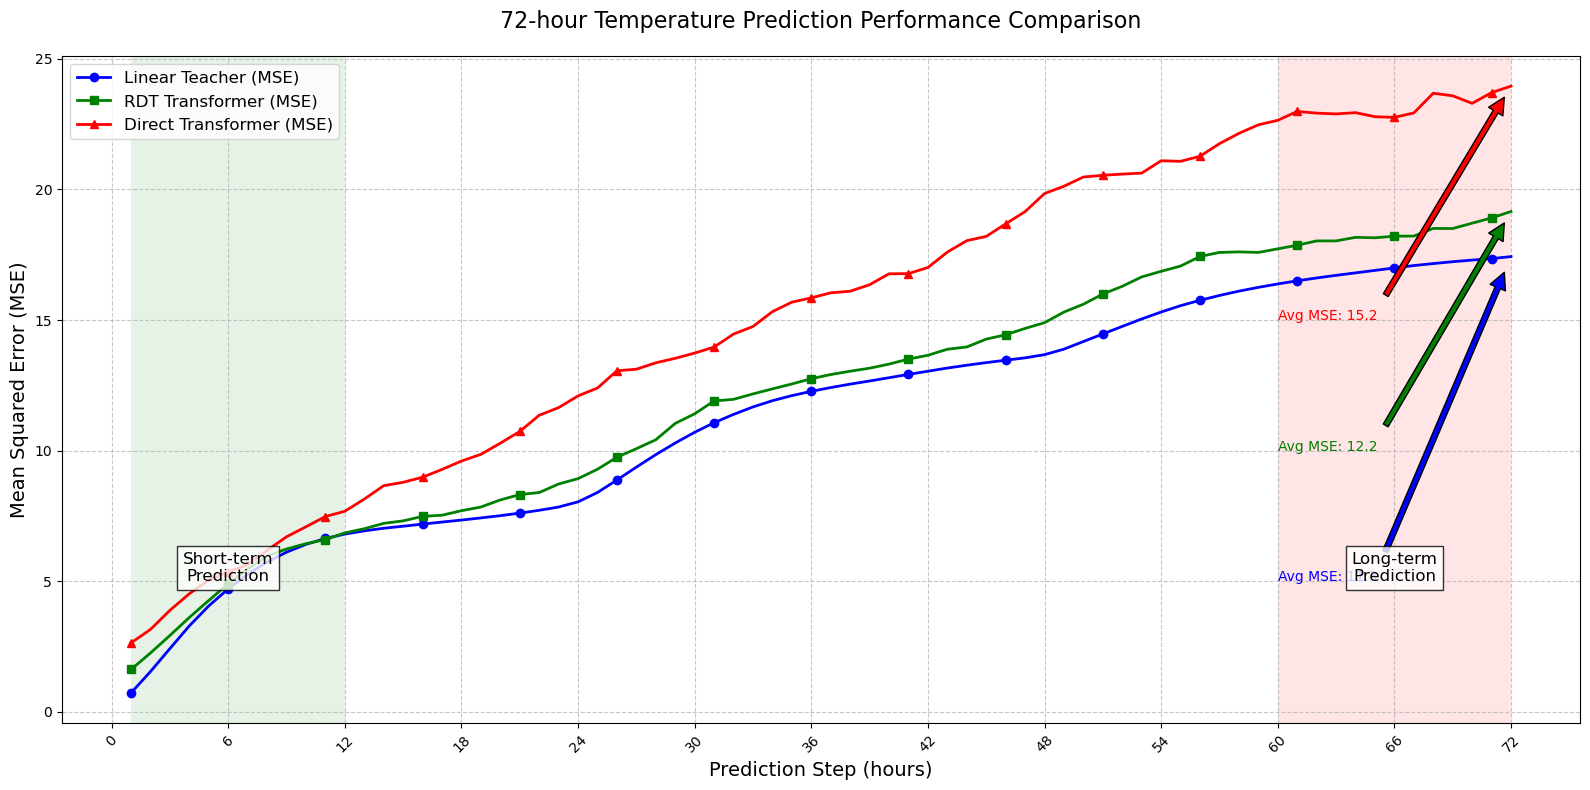

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data from the evaluation results
steps = np.arange(1, 73)  # 1-72 prediction steps

# Linear Teacher MSE values
linear_mse = [
    0.7179, 1.5355, 2.4158, 3.2855, 4.0516, 4.7018, 5.2611, 5.7305, 
    6.1088, 6.4083, 6.6341, 6.8004, 6.9252, 7.0244, 7.1025, 7.1838, 
    7.2623, 7.3385, 7.4206, 7.5071, 7.6045, 7.7117, 7.8379, 8.0363,
    8.3947, 8.8719, 9.3664, 9.8445, 10.2896, 10.7012, 11.0666, 11.3852,
    11.6716, 11.9093, 12.1045, 12.2683, 12.4130, 12.5448, 12.6647, 12.7900,
    12.9176, 13.0388, 13.1600, 13.2685, 13.3688, 13.4601, 13.5511, 13.6728,
    13.8852, 14.1753, 14.4671, 14.7557, 15.0402, 15.3068, 15.5495, 15.7549,
    15.9399, 16.1059, 16.2500, 16.3817, 16.5016, 16.6100, 16.7109, 16.8056,
    16.8998, 16.9954, 17.0850, 17.1617, 17.2329, 17.2951, 17.3516, 17.4286
]

# RDT Transformer MSE values
rdt_mse = [
    1.6159, 2.2472, 2.9179, 3.6086, 4.2595, 4.9003, 5.4642, 5.9610, 
    6.2299, 6.4328, 6.5896, 6.8475, 7.0064, 7.2116, 7.3077, 7.4804, 
    7.5241, 7.6969, 7.8377, 8.1094, 8.3157, 8.3923, 8.7197, 8.9251,
    9.2848, 9.7456, 10.0717, 10.4139, 11.0401, 11.4088, 11.8998, 11.9623,
    12.1706, 12.3621, 12.5508, 12.7525, 12.9115, 13.0390, 13.1550, 13.3113,
    13.5036, 13.6493, 13.8801, 13.9687, 14.2676, 14.4349, 14.6771, 14.8982,
    15.3048, 15.6055, 15.9951, 16.2916, 16.6510, 16.8650, 17.0662, 17.4336,
    17.5875, 17.6092, 17.5883, 17.7255, 17.8639, 18.0290, 18.0299, 18.1655,
    18.1497, 18.2109, 18.2144, 18.5073, 18.5040, 18.7080, 18.9098, 19.1554
]

# Direct Transformer MSE values
direct_mse = [
    2.6344, 3.1494, 3.8813, 4.5160, 5.0400, 5.3541, 5.6310, 6.1781, 
    6.6971, 7.0808, 7.4738, 7.6753, 8.1413, 8.6552, 8.7852, 8.9781, 
    9.2777, 9.5977, 9.8553, 10.2823, 10.7317, 11.3519, 11.6457, 12.0941,
    12.3960, 13.0560, 13.1159, 13.3617, 13.5327, 13.7336, 13.9629, 14.4619,
    14.7507, 15.3200, 15.6843, 15.8490, 16.0417, 16.1025, 16.3516, 16.7695,
    16.7770, 17.0112, 17.6011, 18.0383, 18.2022, 18.6828, 19.1512, 19.8424,
    20.1241, 20.4775, 20.5421, 20.5887, 20.6264, 21.0991, 21.0771, 21.2717,
    21.7543, 22.1480, 22.4748, 22.6482, 22.9886, 22.9226, 22.8941, 22.9411,
    22.7856, 22.7605, 22.9313, 23.6845, 23.5876, 23.2974, 23.7088, 23.9577
]

# Create figure
plt.figure(figsize=(16, 8))

# Plot MSE curves
plt.plot(steps, linear_mse, 'b-o', label='Linear Teacher (MSE)', linewidth=2, markersize=6, markevery=5)
plt.plot(steps, rdt_mse, 'g-s', label='RDT Transformer (MSE)', linewidth=2, markersize=6, markevery=5)
plt.plot(steps, direct_mse, 'r-^', label='Direct Transformer (MSE)', linewidth=2, markersize=6, markevery=5)

# Add annotations for average performance
plt.annotate(f'Avg MSE: {11.3197:.1f}', xy=(72, linear_mse[-1]), xytext=(60, 5),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=10, color='blue')
plt.annotate(f'Avg MSE: {12.1546:.1f}', xy=(72, rdt_mse[-1]), xytext=(60, 10),
             arrowprops=dict(facecolor='green', shrink=0.05),
             fontsize=10, color='green')
plt.annotate(f'Avg MSE: {15.2472:.1f}', xy=(72, direct_mse[-1]), xytext=(60, 15),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=10, color='red')

# Customize the chart
plt.title('72-hour Temperature Prediction Performance Comparison', fontsize=16, pad=20)
plt.xlabel('Prediction Step (hours)', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.xticks(np.arange(0, 73, 6), rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12, loc='upper left')

# Add background color to distinguish regions
plt.axvspan(1, 12, facecolor='green', alpha=0.1)
plt.axvspan(60, 72, facecolor='red', alpha=0.1)
plt.text(6, 5, 'Short-term\nPrediction', ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
plt.text(66, 5, 'Long-term\nPrediction', ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Adjust layout and save
plt.tight_layout()
plt.savefig('72h_model_comparison_mse.png', dpi=300, bbox_inches='tight')
plt.show()